# Validación cruzada y métodos de evaluación de rendimiento

En los cuadernos anteriores, dividimos los datos en dos partes, un conjunto de entrenamiento y otro de test. Utilizamos el de entrenamiento para ajustar el modelo y el de test para evaluar su capacidad de generalización (como se comportaba con datos nuevos, previamente no tratados, lo que podemos denominar una *prueba de realidad*).
<img src="figures/train_test_split.svg" width="100%">


Sin embargo, a menudo, los datos (etiquetados) pueden ser muy valiosos y esta aproximación solo nos deja usar una parte de los datos para entrenar. Además, la evaluación de rendimiento también se basa en un solo subconjunto. Por otro lado, dependiendo de la partición que utilicemos, los resultados pueden ser muy distintos. 
Una forma habitual de construir un modelo aprovechando al máximo los datos y al mismo tiempo obteniendo una estimación robusta del rendimiento es lo que se conoce como **validación cruzada**.
En validación cruzada, los datos se dividen repetidamente en entrenamiento y test, obteniendo un modelo para cada par. Los resultados de test luego se promedian, para así obtener una estimación más robusta del rendimiento.
La forma más habitual de hacer validación cruzada es lo que se conoce como validación cruzada $k$-*fold*, que consiste en dividir los datos en $k$ folds o conjuntos del mismo tamaño (normalmente, $k=5$ o $k=10$). Después, en cada iteración, uno de esos $k$ folds se utiliza como test y el resto como datos de entrenamiento:

<img src="figures/cross_validation.svg" width="100%">


De esta forma, cada patrón estará en el conjunto de test una sola vez y utilizamos todos los datos salvo una $k$-ésima parte para entrenar. Vamos a aplicar esta técnica para entrenar un KNeighborsClassifier en el conjunto iris:

In [1]:
from sklearn.datasets import load_iris
from sklearn.neighbors import KNeighborsClassifier

iris = load_iris()
X, y = iris.data, iris.target

classifier = KNeighborsClassifier()

Las etiquetas en iris están ordenadas, lo que significa que si partimos los datos de forma directa, el primer fold solo tendrá etiquetas de la clase 0, mientras que el último solo tendrá etiquetas de la clase 2:

In [2]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

Para evitar este problema, podemos barajar los datos previamente:

In [3]:
import numpy as np
rng = np.random.RandomState(0)

permutation = rng.permutation(len(X))
X, y = X[permutation], y[permutation]
print(y)

[2 1 0 2 0 2 0 1 1 1 2 1 1 1 1 0 1 1 0 0 2 1 0 0 2 0 0 1 1 0 2 1 0 2 2 1 0
 1 1 1 2 0 2 0 0 1 2 2 2 2 1 2 1 1 2 2 2 2 1 2 1 0 2 1 1 1 1 2 0 0 2 1 0 0
 1 0 2 1 0 1 2 1 0 2 2 2 2 0 0 2 2 0 2 0 2 2 0 0 2 0 0 0 1 2 2 0 0 0 1 1 0
 0 1 0 2 1 2 1 0 2 0 2 0 0 2 0 2 1 1 1 2 2 1 1 0 1 2 2 0 1 1 1 1 0 0 0 2 1
 2 0]


Ahora, podemos implementar fácilmente la validación cruzada $k$-fold:

In [20]:
k = 5
n_samples = len(X)
fold_size = n_samples // k
scores = []
masks = []
#print(fold_size, n_samples)
for fold in range(k):
    # Generar una máscara booleana para los datos de test de este fold
    test_mask = np.zeros(n_samples, dtype=bool)
    test_mask[fold * fold_size : (fold + 1) * fold_size] = True
    # Guardar la máscara para visualizarla después
    masks.append(test_mask)
    # Crear los conjuntos de entrenamiento y test utilizando la máscara
    X_test, y_test = X[test_mask], y[test_mask]
    X_train, y_train = X[~test_mask], y[~test_mask]
    # Ajustar el clasificador
    classifier.fit(X_train, y_train)
    # Obtener el rendimiento y guardarlo
    scores.append(classifier.score(X_test, y_test))

Vamos a comprobar que la máscara de test es correcta:

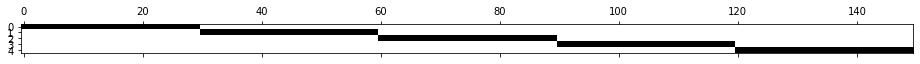

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.matshow(masks, cmap='gray_r')

Ahora observamos los rendimientos obtenidos:

In [6]:
print(scores)
print(np.mean(scores))
print(np.std(scores))

[0.9666666666666667, 0.9, 1.0, 1.0, 0.9333333333333333]
0.96
0.038873012632301994


Como puedes comprobar, el rango de variabilidad es bastante grande, desde un 90% de rendimiento a un 100%. Si hubiéramos hecho una sola partición, hubiéramos obtenido cualquiera de estos rendimientos.

Como la validación cruzada es muy común en aprendizaje automático, hay funciones para hacer todo lo anterior de forma más flexible y con menos código. El paquete ``sklearn.model_selection`` contiene todas las funciones relacionadas con validación cruzada. La función más sencilla es ``cross_val_score`` que recibe un estimador y un dataset y hace todo el proceso de forma automática:

In [24]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(classifier, X, y)
print(scores)
print(np.mean(scores))

[1.         0.93333333 1.         1.         0.93333333]
0.9733333333333334


Como puedes comprobar, por defecto, se utiliza $k=3$. Puedes cambiar el número de folds con el argumento `cv`:

In [8]:
cross_val_score(classifier, X, y, cv=5)

array([1.        , 0.93333333, 1.        , 1.        , 0.93333333])

Además, hay objetos de ayuda en el módulo de validación cruzada que generan los índices para todos los métodos de validación cruzada, incluyendo $k$-fold:

In [9]:
from sklearn.model_selection import KFold, StratifiedKFold, ShuffleSplit

Por defecto, `cross_val_score` utiliza ``StratifiedKFold`` para clasificación, que asegura que la proporción de patrones por clase se respeta en cada fold. Si tenemos un dataset de clasificación binaria con un 90% de patrones de la clase 0, esto significa que en cada fold debería haber un 90% de patrones en la clase 0. Si utilizásemos el método ``KFold`` estándar, sería bastante probable que alguno de los folds tuviese solo patrones de la clase 0. En general, es recomendable utilizar siempre ``StratifiedKFold`` cuando estemos en un problema de clasificación.

``StratifiedKFold`` también nos evita la necesidad de barajar los datos, aunque por defecto esta opción no está activa. Veamos que tipo de folds nos genera en el dataset iris. Cada clase de validación cruzada actúa como un generador de índices de entrenamiento y test:

In [26]:
cv = StratifiedKFold(n_splits=5)
for train, test in cv.split(iris.data, iris.target):
    print(test)

[  0   1   2   3   4   5   6   7   8   9  50  51  52  53  54  55  56  57
  58  59 100 101 102 103 104 105 106 107 108 109]
[ 10  11  12  13  14  15  16  17  18  19  60  61  62  63  64  65  66  67
  68  69 110 111 112 113 114 115 116 117 118 119]
[ 20  21  22  23  24  25  26  27  28  29  70  71  72  73  74  75  76  77
  78  79 120 121 122 123 124 125 126 127 128 129]
[ 30  31  32  33  34  35  36  37  38  39  80  81  82  83  84  85  86  87
  88  89 130 131 132 133 134 135 136 137 138 139]
[ 40  41  42  43  44  45  46  47  48  49  90  91  92  93  94  95  96  97
  98  99 140 141 142 143 144 145 146 147 148 149]


Como puedes ver, siempre hay unos cuantos ejemplos del principio (primera clase), unos cuantos de la mitad (segunda clase) y otros cuantos del final (tercera clase), y así mantenemos la distribución de patrones por clase. Visualicemos la partición:

In [27]:
def plot_cv(cv, features, labels):
    masks = []
    for train, test in cv.split(features, labels):
        mask = np.zeros(len(labels), dtype=bool)
        mask[test] = 1
        masks.append(mask)
    
    plt.matshow(masks, cmap='gray_r')

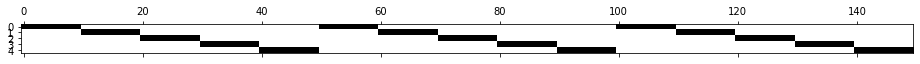

In [29]:
plot_cv(StratifiedKFold(n_splits=5), iris.data, iris.target)

Veamos lo que sucede con el ``KFold`` estándar, que ignora la distribución de patrones por clase.

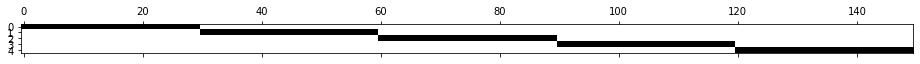

In [13]:
plot_cv(KFold(n_splits=5), iris.data, iris.target)

Recuerda que incrementar el número de folds te dará un conjunto de entrenamiento más grande y una evaluación más robusta, pero también te llevará a la necesidad de hacer más repeticiones y el proceso será más lento:

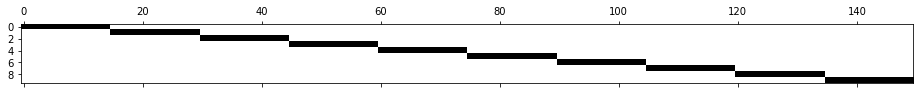

In [14]:
plot_cv(KFold(n_splits=10), iris.data, iris.target)

Otro generador de particiones de validación cruzada bastante útil es el ``ShuffleSplit``. Este generador simplemente parte los datos aleatoriamente varias veces, sin considerar folds. Esto permite que el usuario pueda especificar el número de repeticiones y el tamaño del conjunto de entrenamiento de forma independiente:

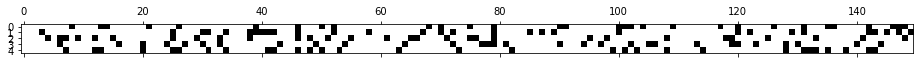

In [15]:
plot_cv(ShuffleSplit(n_splits=5, test_size=.2), iris.data, iris.target)

Si quieres una evaluación más robusta, bastaría con que incrementases el número de particiones:

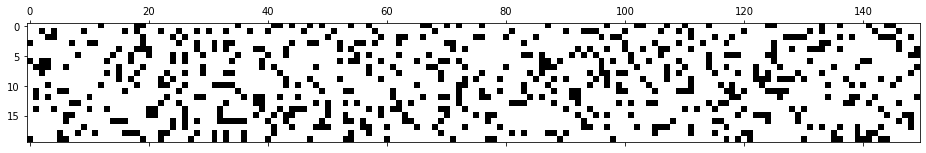

In [16]:
plot_cv(ShuffleSplit(n_splits=20, test_size=.2), iris.data, iris.target)

Cualquiera de estos métodos de validación cruzada se pueden combinar con el `cross_val_score`:

In [17]:
cv = ShuffleSplit(n_splits=5, test_size=.2)
cross_val_score(classifier, X, y, cv=cv)

array([0.93333333, 0.9       , 0.96666667, 0.96666667, 0.96666667])

<div class="alert alert-success">
    <b>EJERCICIO</b>:
     <ul>
      <li>
      Realiza una validación cruzada 3-fold utilizando la clase ``KFold`` en el conjunto de datos iris y sin barajar los datos. ¿Puedes explicar los resultados?
      </li>
    </ul>
</div>

In [33]:
cv = KFold(n_splits = 3)

In [36]:
scores = cross_val_score(classifier, iris.data, iris.target , cv=cv)
print(scores)
print(np.mean(scores))

[0. 0. 0.]
0.0
